In [3]:
# Import basic libraries
import copy # copy variables
import os   # manage paths

import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import tqdm # progress bars
import ROOT

In [30]:
from cernopendata_client import searcher

SERVER_HTTP_URI = "http://opendata.cern.ch"
RECID = 80001
# Check if record with the given recid exists
searcher.verify_recid(server=SERVER_HTTP_URI, recid=80001)
metadata_from_recid = searcher.get_record_as_json(server=SERVER_HTTP_URI, recid=RECID)
print(metadata_from_recid['metadata']['_file_indices'][0]['files'][0]['uri'])


root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019878._000001.pool.root.1


In [1]:
import uproot
import requests
import awkward as ak
import vector

# URL to the file index
file_index_url = "https://opendata.cern.ch/record/80001/file_index/data16_13TeV_Run_00310691_file_index.txt"

# Download the file index
response = requests.get(file_index_url)
if response.status_code != 200:
    raise Exception(f"Failed to download file index: {response.status_code}")
file_index = response.text.splitlines()

# Schema to filter branches
schema = {
    "Electrons": [
        "pt", "eta", "phi",
    ],
    "Muons": [
        "pt", "eta", "phi",
    ],
    "Jets": [
        "pt", "eta", "phi", "m"
    ],
    "BTagging_AntiKt4EMPFlow": [
        "DL1dv01_pb",
    ]
}

# Function to read events according to the schema
def read_events(filename, schema):
    with uproot.open({filename: "CollectionTree"}) as tree:
        events = {}
        for objname, fields in schema.items():
            base = objname
            if objname in ["Electrons", "Muons", "Jets"]:
                base = "Analysis" + objname
                ak_zip = vector.zip
            else:
                ak_zip = ak.zip
            arrays = tree.arrays(
                fields,
                aliases={field: f"{base}AuxDyn.{field}" for field in fields},
            )
            arrays = ak_zip(dict(zip(arrays.fields, ak.unzip(arrays))))
            events[objname] = arrays
        return ak.zip(events, depth_limit=1)

# List to store events from each ROOT file
events_list = []

# Iterate over each ROOT file URL in the file index
for file_url in file_index[:20]:
    # Create the full URL to the ROOT file (make sure it is HTTPS)
    root_url = file_url.strip()
    print(f"Processing ROOT file: {root_url}")
    
    try:
        # Read events from the ROOT file according to the schema
        events = read_events(root_url, schema)
        events_list.append(events)

    except Exception as e:
        print(f"Error processing {root_url}: {e}")

# Optionally, combine all events into one (if required)
if events_list:
    combined_events = ak.concatenate(events_list, axis=0)
    print("Successfully combined all events.")
else:
    print("No events were processed.")

# Optionally, you can work with combined_events here or perform further analysis
# Example: access electron data in the combined events
# electrons = combined_events["Electrons"]


Processing ROOT file: root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37020312._000001.pool.root.1
Processing ROOT file: root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37020312._000002.pool.root.1
Processing ROOT file: root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37020312._000003.pool.root.1
Processing ROOT file: root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37020312._000004.pool.root.1
Processing ROOT file: root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37020312._000005.pool.root.1
Processing ROOT file: root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37020312._000006.pool.root.1
Processing ROOT file: root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37020312._000007.pool.root.1
Processing ROOT file: root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLI

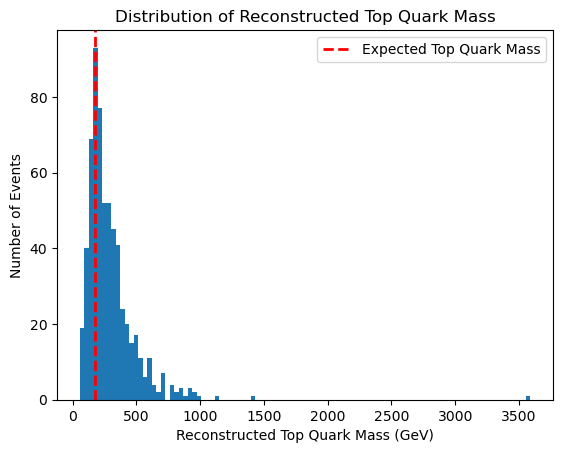

Total events: 920206
Events after filtering: 624


In [4]:
GeV = 1000.

def selected_electrons(el):
    return el[(el.pt > 30 * GeV) & (abs(el.eta) < 2.47)]

def selected_muons(mu):
    return mu[(mu.pt > 30 * GeV) & (abs(mu.eta) < 2.47)]

def selected_jets(j):
    return j[(j.pt > 30 * GeV) & (abs(j.eta) < 2.47)]

def no_overlap(obj1, obj2, deltaR=0.4):
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))
    return ak.all(obj1.deltaR(obj2) > deltaR, axis=-1)

def mjjj(jets):
    candidates = ak.combinations(jets, 3)
    j1, j2, j3 = ak.unzip(candidates)
    has_b = (j1.is_bjet + j2.is_bjet + j3.is_bjet) > 0
    candidates["p4"] = j1 + j2 + j3
    candidates = candidates[has_b]
    candidates = candidates[ak.argmax(candidates.p4.pt, axis=1, keepdims=True)]
    return candidates.p4.mass

def processed(events):
    events = copy.copy(events) # shallow copy
    events["Jets", "btag_prob"] = events.BTagging_AntiKt4EMPFlow.DL1dv01_pb
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Jets"] = selected_jets(events.Jets)
    events["Jets"] = events.Jets[no_overlap(events.Jets, events.Electrons)]
    events["Jets", "is_bjet"] = events.Jets.btag_prob > 0.85
    events = events[
        (ak.num(events.Jets) >= 4) # at least 4 jets
        & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly one lepton
        & (ak.num(events.Jets[events.Jets.is_bjet]) >= 2) # at least two btagged jets with prob > 0.85
    ]
    return ak.to_packed(events)

events = processed(combined_events)
plt.hist(ak.flatten(mjjj(events.Jets) / GeV, axis=None), bins=100)
plt.xlabel("Reconstructed Top Quark Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Reconstructed Top Quark Mass")
plt.axvline(172.76, color='r', linestyle='dashed', linewidth=2, label='Expected Top Quark Mass')
plt.legend()
plt.show()

print('Total events:', len(combined_events))
print('Events after filtering:', len(events))

In [27]:
from cernopendata_client import searcher

SERVER_HTTP_URI = "http://opendata.cern.ch"

# Check if record with the given recid exists
searcher.verify_recid(server=SERVER_HTTP_URI, recid=80001)
metadata_from_recid = searcher.get_record_as_json(server=SERVER_HTTP_URI, recid=80001)
print(metadata_from_recid['metadata']['_file_indices'][0]['files'][0]['uri'])

root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019878._000001.pool.root.1
